In [11]:
# torch library
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as distrib 

# for example dataset 
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# for plotting 
import matplotlib.pyplot as plt 
import sys, os 
from pathlib import Path
import json 

print('Packages imported')

Packages imported


In [12]:
# import all type hints you might need 
from typing import Callable

In [13]:
# load a couple of data sets 

main_path = Path(os.getcwd())

# --- MNIST
dataset_path = main_path.joinpath('mnist')
batch_size = 100 

def get_transforms(with_normalize=False) -> Callable:
    if not with_normalize:
        return transforms.Compose([
            transforms.ToTensor()])
    else:
       return transforms.Compose([
           transforms.ToTensor(),
           transforms.Normalize((0.1307,), (0.3081,))]) 

mnist_trans = get_transforms(True)

mnist_train_dataset = MNIST(dataset_path, transform=mnist_trans, train=True, download=True)
mnist_test_dataset = MNIST(dataset_path, transform=mnist_trans, train=False, download=True)
print('Done loading MNIST')
# ---

Done loading MNIST


In [14]:
''' 
Basic neural networks
    - feed forward networks 
    - convolutional networks
    - recurrent networks (RNN, LSTMS, ... )
    - transformers
'''

import abc 

# --- Basic neural networks --- 
class BaseNeuralNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, activation):
        super(BaseNeuralNet, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.activation = activation
        self.output_dim = output_dim

        # (feature learning) hidden layers (stacking of multiple of hidden units + nonlinearity(per neuron) + batch_normalization + [dropouts] + [layer normalization])
        self.hidden_layers = None 
        self.fl = None
        
        self._init_hidden_layers()
        self._final_layer()

        # predict probablity
        self.prob_dist = nn.LogSoftmax(dim=1)

        
        assert self.hidden_layers is not None, 'Hidden layers are not initialized'
        assert self.fl is not None, 'Final layer is not initialized'


    @abc.abstractmethod
    def _init_hidden_layers(self): ...
    
    @abc.abstractmethod
    def _transform_input(self, x): ...

    @abc.abstractmethod
    def _final_layer(self): ...

    def forward(self, x):
        x = self._transform_input(x)
        x = self.hidden_layers(x) # this is the forward pass
        probs = self.prob_dist(self.fl(x))   # predicts the probablity as a multinomial distribution
        return probs


# --- Feed forward neural networks ---
class FeedForwardNeuralNet(BaseNeuralNet):
    def __init__(self, input_dim, hidden_dim, output_dim, activation):
        super(FeedForwardNeuralNet, self).__init__(input_dim, hidden_dim, output_dim, activation)

    def _init_hidden_layers(self):
        self.hidden_layers = nn.Sequential(
            nn.Linear(self.input_dim, self.hidden_dim, bias=False),               # what does bias do?
            self.activation,
            nn.Linear(self.hidden_dim, self.hidden_dim), 
            self.activation,
            nn.BatchNorm1d(self.hidden_dim),                          # what does batch normalization do?
            nn.Linear(self.hidden_dim, self.hidden_dim),
            self.activation,
            nn.BatchNorm1d(self.hidden_dim),
        )

    def _final_layer(self):
        # final hidden layer (linear classifier)
        self.fl = nn.Linear(self.hidden_dim, self.output_dim)

    def _transform_input(self, x):
        return x.flatten(start_dim=1)

# --- Convolutional neural networks ---
class ConvolutionalNeuralNet(BaseNeuralNet):
    def __init__(self, input_dim, hidden_dim, output_dim, activation):
        super(ConvolutionalNeuralNet, self).__init__(input_dim, hidden_dim, output_dim, activation)

    def _init_hidden_layers(self):
        self.hidden_layers = nn.Sequential(
            nn.Conv2d(self.input_dim, self.hidden_dim, kernel_size=3, stride=1, padding=1),   # what is hidden_dim, kernel_size, stride, padding?
            self.activation,
            nn.BatchNorm2d(self.hidden_dim),
            nn.Conv2d(self.hidden_dim, self.hidden_dim, kernel_size=3, stride=1, padding=1),
            self.activation,
            nn.BatchNorm2d(self.hidden_dim),
        )

    def _final_layer(self):
        # final hidden layer (linear classifier)
        self.fl = nn.Sequential(
            nn.Flatten(start_dim=1),
            nn.Linear(self.hidden_dim * 28 * 28, self.output_dim)
            )

    def _transform_input(self, x):
        return x

# --- Recurrent neural networks ---
# class RecurrentNeuralNet(BaseNeuralNet):
#     def __init__(self, input_dim, hidden_dim, output_dim, activation):
#         super(RecurrentNeuralNet, self).__init__(input_dim, hidden_dim, output_dim, activation)

#     def _init_hidden_layers(self):
#         return nn.LSTM(self.hidden_dim, self.hidden_dim, batch_first=True)

#     def _transform_input(self, x):
#         return x

print('Network definition is done.')

Network definition is done.


In [15]:
# How to train and eval a neural network

class NetworkTrainer:
    # FIXME: addapt class to be agnostic to training scheme: enable to support supervised, unsupervised,  self-supervised, ...
    def __init__(self, optimizer, loss_fn, device):
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.device = device

    def train_neural_net(self, model, train_loader, test_loader, epochs=10) -> None:
        print('Start model training ... ') 
        for epoch in range(epochs + 1):
            train_loss = self._train_step(model, train_loader)
            print(f'Epoch {epoch}: Train loss: {train_loss}')
            if epoch % 5 == 0:
                #test_loss = self.eval_neural_net(model, test_loader)
                accuracy = self._accuracy(model, test_loader)
                print('--------------------')
                print(f'Epoch {epoch}: correct classification rate : {accuracy * 100.}%')
                print('--------------------')
            

    def _train_step(self, model, train_loader):
        model.train()
        total_loss = 0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(self.device), target.to(self.device)
            self.optimizer.zero_grad()  # removes any 
            output = model(data)
            loss = self.loss_fn(output, target)
            loss.backward()
            self.optimizer.step()
            total_loss += loss.item()

        # average loss over all batches 
        return total_loss / len(train_loader)


    def eval_neural_net(self, model, test_loader):
        model.eval()
        total_loss = 0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(self.device), target.to(self.device)
                output = model(data)
                total_loss += self.loss_fn(output, target).item()
        # 
        return total_loss / len(test_loader)

    def _accuracy(self, model, data_loader) -> torch.Tensor:
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data, target in data_loader:
                data, target = data.to(self.device), target.to(self.device)
                output = model(data)
                _, predicted = torch.max(output.data, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()
        # 
        # FIXME: decompose this into precision, recall, balanced accuracy, f1-score, ...
        return correct / total


# --- Training a neural network ---
# check if cuda is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# select different datasets. 
train_dataset = mnist_train_dataset
test_dataset = mnist_test_dataset

# initalize data loaders
batch_size = 50

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# initalize the model
input_dim = 784         # input dimension
hidden_dim = 100        # feature dimension
output_dim = 10         # number of classification class
activation = nn.ReLU()  # activation function

#-- select model 
# feed-forward neural network
model = FeedForwardNeuralNet(input_dim, hidden_dim, output_dim, nn.ReLU()).to(device)

# convolutional neural network
# input_dim = 1
# hidden_dim = 32
# model = ConvolutionalNeuralNet(input_dim, hidden_dim, output_dim, nn.ReLU()).to(device)


# select optimizer and loss functions 
learning_rate = 0.001
epochs = 10
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
loss_fn = nn.NLLLoss()


# training config 
train_config = {
    'optimizer':{'optimizer_name': optimizer.__class__.__name__, 'learning_rate': learning_rate},
    'loss_fn': loss_fn.__class__.__name__,
    'device': device.type,
    'model' : {'model name': model.__class__.__name__, 'activation': activation.__class__.__name__},
    'train_details':{'epoch': epochs, 'batch_size': batch_size}
}

print('++ Training config ++')
print(json.dumps(train_config, indent=2))
print('\n')
# initalize the training loop

trainer = NetworkTrainer(optimizer, loss_fn, device)
trainer.train_neural_net(model, train_loader, test_loader, epochs=epochs)
print('Done training')


++ Training config ++
{
  "optimizer": {
    "optimizer_name": "SGD",
    "learning_rate": 0.001
  },
  "loss_fn": "NLLLoss",
  "device": "cuda",
  "model": {
    "model name": "FeedForwardNeuralNet",
    "activation": "ReLU"
  },
  "train_details": {
    "epoch": 10,
    "batch_size": 50
  }
}


Start model training ... 
Epoch 0: Train loss: 0.8409258914242188
--------------------
Epoch 0: correct classification rate : 90.39%
--------------------
Epoch 1: Train loss: 0.3849004373078545
Epoch 2: Train loss: 0.2902961996818582
Epoch 3: Train loss: 0.24018969442074498
Epoch 4: Train loss: 0.20851869101946552
Epoch 5: Train loss: 0.18726313940870265
--------------------
Epoch 5: correct classification rate : 95.52000000000001%
--------------------
Epoch 6: Train loss: 0.16797171346532802
Epoch 7: Train loss: 0.15501036944954347
Epoch 8: Train loss: 0.14181146262679248
Epoch 9: Train loss: 0.1328271376527846
Epoch 10: Train loss: 0.12397403878004601
--------------------
Epoch 10: correct c



+++ Example activation functions with respect to forward/backward information flow +++




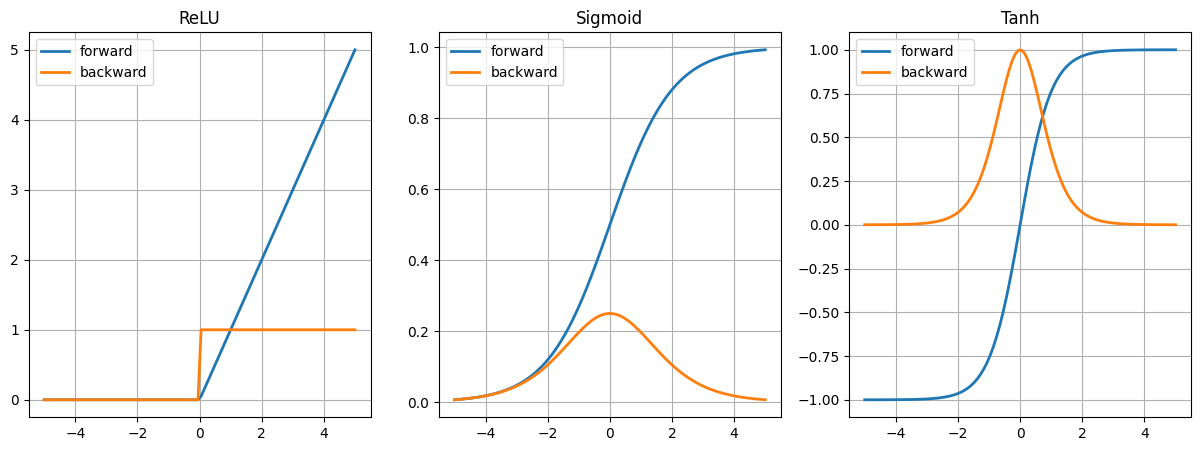

' \n--- discuss dead neurons, vanishing/exploding gradients, residual connections\n'

In [16]:
# common good to keep in mind concepts introduced in neural networks.

##### activation functions

class Activation(nn.Module):
    def __init__(self, activation_name):
        super(Activation, self).__init__()
        self.activation_name = activation_name

    def get_grad(self, x) -> torch.Tensor:
        #if not x.requires_grad:
        x = x.clone().requires_grad_()
        out = self.forward(x)
        out.sum().backward()
        return x.grad

# few activation function
class Sigmoid(Activation):
    def __init__(self):
        super(Sigmoid, self).__init__('Sigmoid')

    def forward(self, x):
        #return torch.sigmoid(x)
        return  1 / (1 + torch.exp(-x))

class Tanh(Activation):
    def __init__(self):
        super(Tanh, self).__init__('Tanh')

    def forward(self, x):
        x_exp, neg_x_exp = torch.exp(x), torch.exp(-x)
        return (x_exp - neg_x_exp) / (x_exp + neg_x_exp)

class ReLU(Activation):
    def __init__(self):
        super(ReLU, self).__init__('ReLU')

    def forward(self, x):
        return torch.max(x, torch.tensor(0.))

# visualize activation functions
def plot_act(act_fns: list):
    x = torch.linspace(-5, 5, 100)
    _, ax = plt.subplots(1, len(act_fns), figsize=(15, 5))
    for c, act_fn in enumerate(act_fns):
        y = act_fn(x)
        ax[c].plot(x.numpy(), y.numpy(), linewidth=2, label='forward')
        ax[c].plot(x.numpy(), act_fn.get_grad(x).numpy(), linewidth=2, label='backward')
        ax[c].grid(True)
        ax[c].axis('tight')
        ax[c].legend()
        ax[c].set_title(act_fn.activation_name)
    print('\n')
    print('+++ Example activation functions with respect to forward/backward information flow +++')
    print('\n')
    plt.show()

plot_act([ReLU(), Sigmoid(), Tanh()])

''' 
--- discuss dead neurons, vanishing/exploding gradients, residual connections
'''

In [ ]:
# gradient decent and iterative optimizers. 

In [17]:
# Generative model + autoencoders. (VAE - variational auto encoders)
""" 
Autoencoders: 
    - compress signal   (encoder)
    - decompress signal (decoder)

VAE (variational auto encoders)
    - main problem: learn p(x)  --> maximizning log p(x) is too dificult to do.
    - solution:
        - estimate approximate posterior ~ q(z|x) --> ideally the marginal matches hte prior p(z)
            - these use to be a difficult problem until amortization via reparametrization trick is invented. 
        - use the approximate posterior to estimate the conditional log likelihood of the data. p(x|z) (integral is too difficult, so MCMC is used to approximate)
        - Train model to do END-TO-END optimization of the ELBO (evidence lower bound)
"""


class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, activation):
        super(Encoder, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.activation = activation

        self.encoder = nn.Sequential(
            nn.Linear(self.input_dim, self.hidden_dim),
            self.activation,
            nn.Linear(self.hidden_dim, self.hidden_dim),
            self.activation,
            nn.Linear(self.hidden_dim, self.latent_dim * 2)  # mean and variance
        )

    def forward(self, x):
        x = x.flatten(start_dim=1)
        return self.encoder(x)

class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim, activation):
        super(Decoder, self).__init__()
        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.activation = activation

        self.decoder = nn.Sequential(
            nn.Linear(self.latent_dim, self.hidden_dim),
            self.activation,
            nn.Linear(self.hidden_dim, self.hidden_dim),
            self.activation,
            nn.Linear(self.hidden_dim, self.output_dim)
        )

    def forward(self, z):
        return torch.sigmoid(self.decoder(z))


class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, activation, device):
        super(VAE, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.activation = activation
        self.device = device

        self.encoder = Encoder(input_dim, hidden_dim, latent_dim, activation)
        self.decoder = Decoder(latent_dim, hidden_dim, input_dim, activation)

    def reparametrize(self, mean, sigma):
        sample_z =  mean + torch.exp(0.5 * sigma) * torch.randn_like(mean).to(self.device)
        return sample_z

    def forward(self, x):
        # encode
        x = x.flatten(start_dim=1)
        z_mean, z_log_var = torch.chunk(self.encoder(x), 2, dim=1)  # prediction of mean and variance for posterior: q(z|x) (assmed to be factored gaussian).
        
        # reparametrization trick (mathematically can be worked out from change-of-variable formula)
        z_sample = self.reparametrize(z_mean, z_log_var)

        # decode
        x_reconstructed = self.decoder(z_sample)
        return x_reconstructed, z_sample, z_mean, z_log_var

class ELBO:
    def __call__(self, x, x_reconstructed, z_mean, z_log_var):
        # reconstruction loss
        x = x.flatten(start_dim=1)
        reconstruction_loss = F.binary_cross_entropy(x_reconstructed, x, reduction='sum')
        # KL divergence
        kl_divergence = -0.5 * torch.sum(1 + z_log_var - z_mean.pow(2) - z_log_var.exp())

        return reconstruction_loss + kl_divergence

print('Defining VAE is done.')

Defining VAE is done.


In [27]:
def train(model, train_loader, optimizer, loss_fn, epochs, batch_size, device_vae):
    model.train()
    counter = 0
    for epoch in range(epochs + 1):
        total_loss = 0
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.to(device_vae)
            optimizer.zero_grad()
            x_reconstructed, z, z_mean, z_log_var = model(data)
            loss = loss_fn(data, x_reconstructed, z_mean, z_log_var)  # ELBO, lower bound of the log-likleihood (upper-bound of negative log-likelihood)

            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        if counter == 0:
            counter = (batch_idx * batch_size)

        print(f'Epoch {epoch}: Negative log likelihood: {total_loss / counter}')


# train and sample from VAE model. 
input_dim = 28 * 28 # 784
hidden_dim = 400 
latent_dim = 50
activation = nn.Tanh()
device_vae = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
epoch = 20
batch_size = 100

# model definition. 
model_vae = VAE(input_dim=input_dim, hidden_dim=hidden_dim, latent_dim=latent_dim, activation=activation, device=device_vae).to(device_vae)
loss_fn = ELBO()

# optimizer
learning_rate = 0.001
optimizer = torch.optim.Adam(model_vae.parameters(), lr=learning_rate)


mnist_train_dataset_vae = MNIST(dataset_path, transform=get_transforms(), train=True, download=True)
train_loader = DataLoader(mnist_train_dataset_vae, batch_size=batch_size, shuffle=True)

# train and test model. 
print('Begin training ... ')
train(model_vae, train_loader, optimizer, loss_fn, epochs=epoch, batch_size=batch_size, device_vae=device_vae)


Begin training ... 
Epoch 0: Negative log likelihood: 181.92728763433848
Epoch 1: Negative log likelihood: 130.93377553083263
Epoch 2: Negative log likelihood: 119.71264312591298
Epoch 3: Negative log likelihood: 114.51410360040171
Epoch 4: Negative log likelihood: 111.3637934643677
Epoch 5: Negative log likelihood: 109.42445832572517
Epoch 6: Negative log likelihood: 108.06698607379487
Epoch 7: Negative log likelihood: 107.02410744796015
Epoch 8: Negative log likelihood: 105.99354319373435
Epoch 9: Negative log likelihood: 105.23437501630322
Epoch 10: Negative log likelihood: 104.6983993830864
Epoch 11: Negative log likelihood: 104.19266094532554
Epoch 12: Negative log likelihood: 103.62973746934996
Epoch 13: Negative log likelihood: 103.17758580381364
Epoch 14: Negative log likelihood: 102.83635704690109
Epoch 15: Negative log likelihood: 102.47366160397537
Epoch 16: Negative log likelihood: 102.14378329116235
Epoch 17: Negative log likelihood: 101.84451299040067
Epoch 18: Negative l

.... randomly sampled images ... 


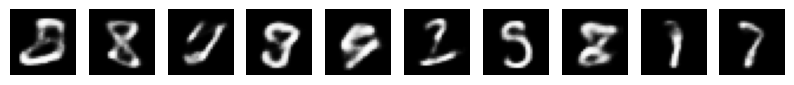

.... reconstructed images ... 

 original


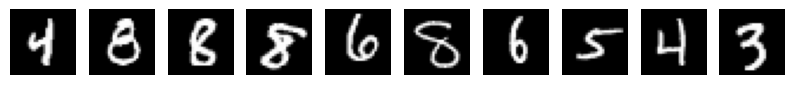


 reconstructed



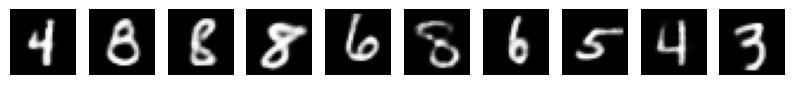

.... interpolated images ... 


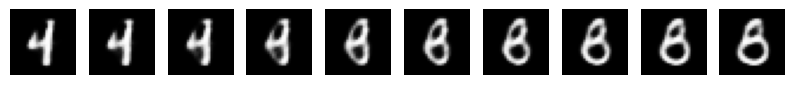

Done training VAE


In [ ]:
# visualization. random sampling, reconstruction, interpolation, ...

def visualize_imgs_grid(imgs):
    imgs = imgs.detach().cpu().numpy()
    _, ax = plt.subplots(1, 10, figsize=(10, 2))
    for i in range(10):
        ax[i].imshow(imgs[i].reshape(28, 28), cmap='gray')
        ax[i].axis('off')
    plt.show()

def sample_vae(model, device, n_samples=10):
    model.eval()
    with torch.no_grad():
        z = torch.randn(n_samples, latent_dim).to(device) ### randomly sampled data points from the PRIOR and not eh approximate posterior. For this to be effective the marginal posterior has to be close to the prior.
        samples = model.decoder(z)
    return samples

def reconstruct_vae(model, data, device):
    model.eval()
    with torch.no_grad():
        x_reconstructed, _, _, _ = model(data)
    return x_reconstructed


def interpolate_vae(model, data, device, n_steps=10):
    model.eval()
    with torch.no_grad():
        z1, z2 = model.encoder(data[:2].flatten(start_dim=1))
        z1, z2 = z1[:latent_dim], z2[:latent_dim]

        # NOTE: this is based on the assumption the latent space is linear. Hence, the shortest distance between two points is a straight line.
        z = torch.stack([z1 + (z2 - z1) * i / n_steps for i in range(n_steps)], dim=0)
        interpolated = model.decoder(z)
    return interpolated



samples = sample_vae(model_vae, device_vae)
print('.... randomly sampled images ... ')
visualize_imgs_grid(samples)

print('.... reconstructed images ... ')
data, _ = next(iter(train_loader))
data = data.to(device_vae)
reconstructed = reconstruct_vae(model_vae, data, device_vae)

print('\n original')
visualize_imgs_grid(data)

print('\n reconstructed\n')
visualize_imgs_grid(reconstructed)

# interpolation
interpolated = interpolate_vae(model_vae, data, device_vae)
print('.... interpolated images ... ')
visualize_imgs_grid(interpolated)

print('Done training VAE')

In [ ]:
# Applied ml (metric learning) --> select few examples. 